# Installation

Run all the cells in the notebook, in order to install/update the necessary software.

Widgets are used for defining individual research parameters. They are filled with reasonable example values.

In [1]:
%load_ext autoreload

In [2]:
%pip uninstall -y tempo_embeddings
%pip install -e ..

Found existing installation: tempo_embeddings 0.0.1
Uninstalling tempo_embeddings-0.0.1:
  Successfully uninstalled tempo_embeddings-0.0.1
Note: you may need to restart the kernel to use updated packages.
Obtaining file:///Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for tempo_embeddings (pyproject.toml) ... done
  Created wheel for tempo_embeddings: filename=tempo_embeddings-0.0.1-0.editable-py3-none-any.whl size=9831 sha256=ab58c6c0abbe6796396e74fe26b495ed11c33b5bd2b6a29b2abdb373595e2306
  Stored in directory: /private/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/pip-ephem-wheel-cache-jpng_h9m/wheels/9d/dd/1c/d0e8ab6bde11a84556c00bd645333aaad0b90e2c38e11b0ed1
Successfully built tempo_embeddings
Note: you may need to r

In [3]:
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


# Initialize Database

This part of the notebook makes the initial connection to the database

In [4]:
from ipywidgets import widgets

from tempo_embeddings.settings import WEAVIATE_SERVERS

default_host = WEAVIATE_SERVERS[0][1]

host_selector = widgets.Dropdown(
    options=WEAVIATE_SERVERS, value=default_host, description="DB Server:"
)
host_selector

Dropdown(description='DB Server:', options=(('UU', ('semantics-of-sustainability.hum.uu.nl', 443, True)), ('Re…

In [5]:
from tempo_embeddings import settings

weaviate_api_key = widgets.Password(
    description="Weaviate API Key", value=settings.WEAVIATE_API_KEY or ""
)
weaviate_api_key

Password(description='Weaviate API Key')

In [6]:
from tempo_embeddings.embeddings.weaviate_database import WeaviateDatabaseManager
from tempo_embeddings.settings import DEFAULT_LANGUAGE_MODEL

host, port, secure = host_selector.value

db = WeaviateDatabaseManager.from_args(
    model_name=DEFAULT_LANGUAGE_MODEL,
    http_host=host,
    http_port=port,
    http_secure=secure,
    api_key=weaviate_api_key.value,
)

/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/google/protobuf/runtime_version.py:112: UserWarning: Protobuf gencode version 5.27.2 is older than the runtime version 5.28.2 at grpc_health/v1/health.proto. Please avoid checked-in Protobuf gencode that can be obsolete.
  warnings.warn(
/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/weaviate/warnings.py:133: DeprecationWarning: Dep005: You are using weaviate-client version 4.6.7. The latest version is 4.10.2.
            Consider upgrading to the latest version. See https://weaviate.io/developers/weaviate/client-libraries/python for details.
  warnings.warn(


# Search

The `Search` part of the notebook defines the initial corpus to work with.

It defines one or multiple corpora, and a search term. Only documents from the selected corpora that contain the search term(s) are part of the initial corpus.

Furthermore, documents can be excluded through their metadata, for instance if their `genre` field has the value `advertentie`.

In [7]:
from ipywidgets import widgets

corpora = sorted(db.get_available_collections())

collection_selector = widgets.SelectMultiple(
    options=corpora,
    value=["PeopleAndParliament"],
    description="Choose one or multiple collections:",
    disabled=False,
    layout={"width": "max-content"},
    rows=len(corpora),
)
collection_selector

SelectMultiple(description='Choose one or multiple collections:', index=(3,), layout=Layout(width='max-content…

In [8]:
text_widgets = [
    widgets.Text(description="Search Term:", value="duurzaam"),
    widgets.Text(
        description="Search Term:", value="milieu", placeholder="Enter a term"
    ),
    widgets.Text(description="Search Term:", placeholder="Enter a term"),
    widgets.Text(description="Search Term:", placeholder="Enter a term"),
    widgets.Text(description="Search Term:", placeholder="Enter a term"),
]

widgets.VBox(text_widgets)

# Plot Frequencies

This section gives an overview over de relative frequency of the search term(s) defined above.

Note: dependending on the number and size of selected corpora, this may take very long -- and possibly time out so that an error is thrown.
You can either ignore this, or wait a short while and retry until the server has finished processing the request.

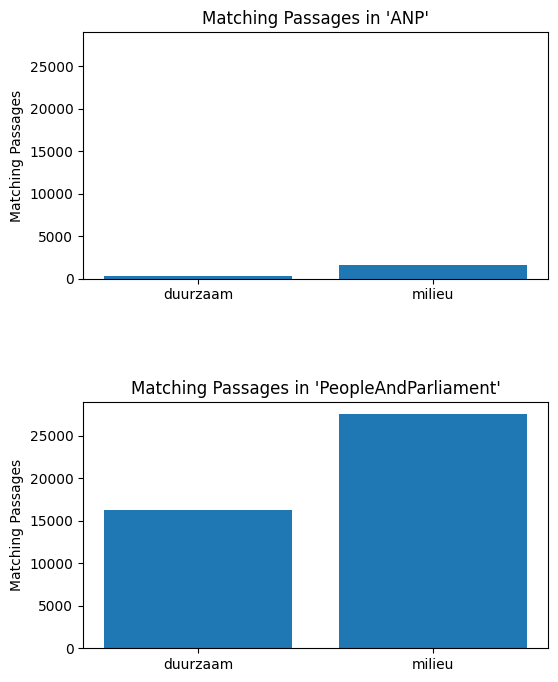

In [25]:
import matplotlib.pyplot as plt

search_terms: list[str] = [
    widget.value.strip() for widget in text_widgets if widget.value
]
if not search_terms:
    raise RuntimeError("No seach terms provided.")

fig, axs = plt.subplots(
    len(collection_selector.value),
    sharey=True,
    figsize=(3 * len(search_terms), 4 * len(collection_selector.value)),
)
plt.subplots_adjust(hspace=0.5)  # Increase the height space between subplots

if len(collection_selector.value) == 1:
    axs = [axs]


for ax, collection in zip(axs, collection_selector.value):
    total_count = db.doc_frequency("", collection)

    ax.set_title(f"Matching Passages in '{collection}'")
    ax.set_ylabel("Matching Passages")

    term_freqs = [db.doc_frequency(term, collection) for term in search_terms]

    ax.bar(search_terms, term_freqs)

## Frequencies Per Year

This subsection further refines the corpus selection through selecting a range of year, and gives more frequency insights.

In [26]:
start = 1850
end = 2024

year_range = widgets.SelectionRangeSlider(
    options=[str(i) for i in range(start, end + 1)],
    index=(1950 - start, end - start),
    description="Years",
)
year_range

SelectionRangeSlider(description='Years', index=(100, 174), options=('1850', '1851', '1852', '1853', '1854', '…

In [27]:
import pandas as pd
from tqdm import tqdm

doc_freqs = pd.DataFrame(
    columns=search_terms,
    index=pd.MultiIndex.from_product(
        (
            collection_selector.value,
            range(int(year_range.value[0]), int(year_range.value[1])),
        ),
        names=["collection", "year"],
    ),
)

for collection in tqdm(collection_selector.value, unit="collection"):
    for term in search_terms:
        term_freqs = db.doc_frequencies_per_year(
            term, collection, int(year_range.value[0]), int(year_range.value[1])
        )
        for year, freq in term_freqs.items():
            doc_freqs.at[(collection, year), term] = freq

100%|██████████| 2/2 [00:09<00:00,  4.64s/collection]


In [28]:
doc_freqs.index.get_level_values("collection").unique()

Index(['ANP', 'PeopleAndParliament'], dtype='object', name='collection')

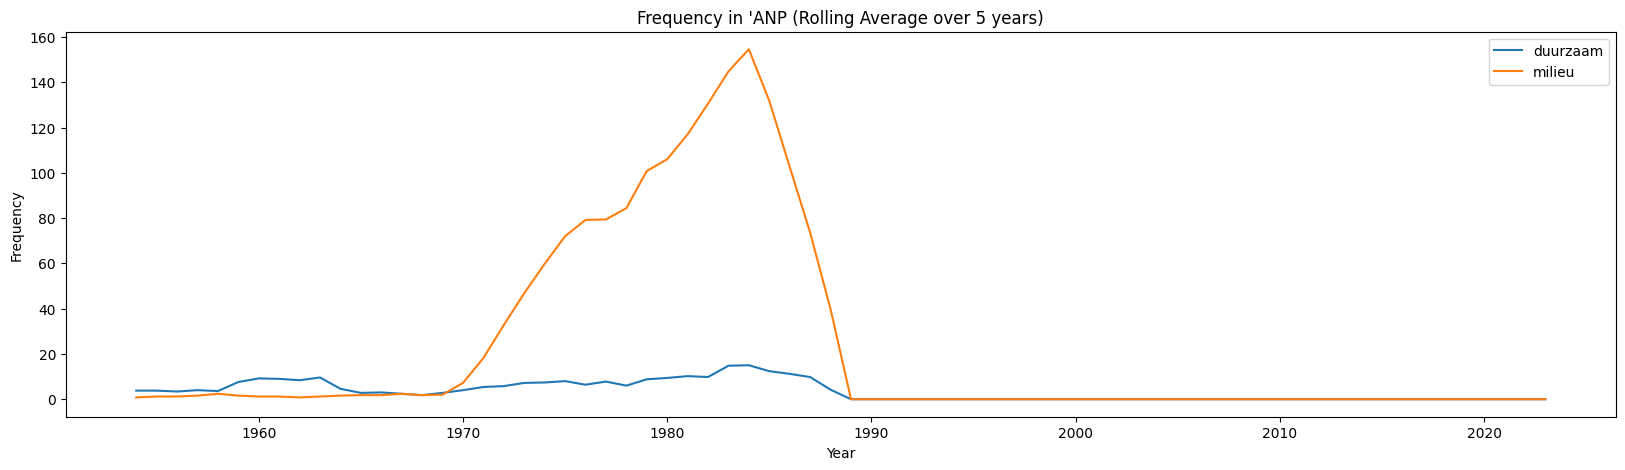

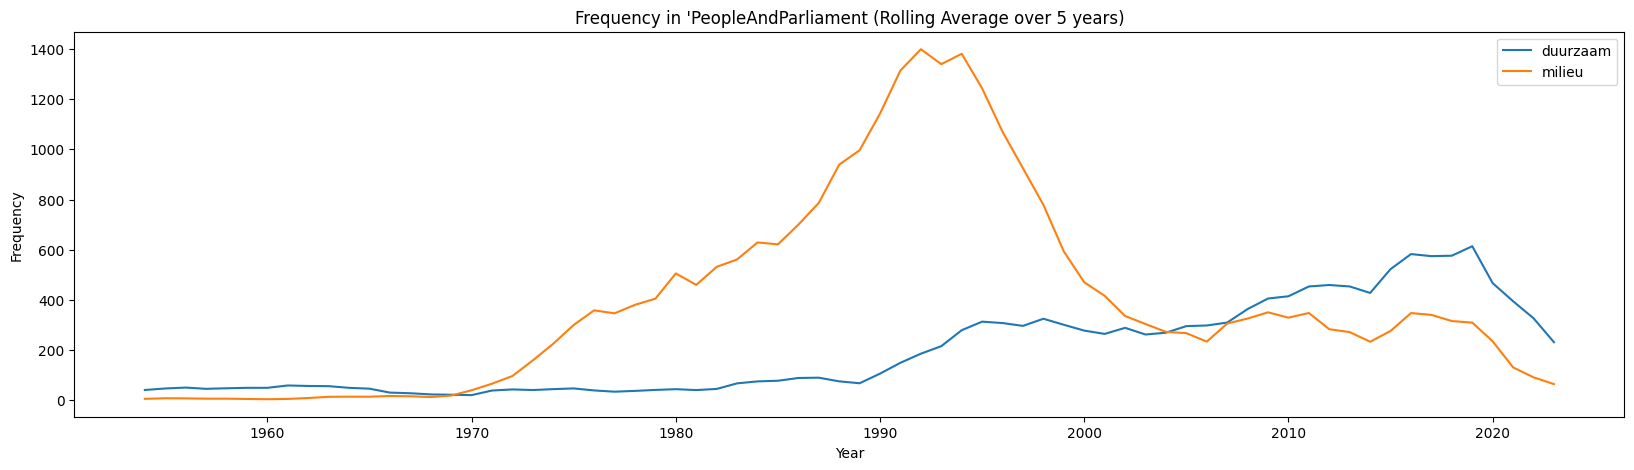

In [29]:
window_size = 5

for collection in doc_freqs.index.get_level_values("collection").unique():
    doc_freqs.loc[collection].rolling(window_size).mean().plot(
        figsize=(20, 5),
        title=f"Frequency in '{collection} (Rolling Average over {window_size} years)",
        xlabel="Year",
        ylabel="Frequency",
    )

# Create Corpus

This section creates the actual corpus for in-depth analysis below.

In [30]:
corpora = [
    db.get_corpus(
        collection,
        [term],
        year_from=year_range.value[0],
        year_to=year_range.value[1],
        include_embeddings=True,
        limit=5000,
    )
    for collection in collection_selector.value
    for term in search_terms
]

## Expand Corpus with Close Passages

This section expands the corpus created above by semantically close passages. The passages above have been selected through the search term(s), along with metadata and year range.

Here, further passages are added by retrieving similar passages, regardless of the exact words.

The `distance` indicates the relative proximity required for such added text passages.

In [31]:
distance_widget = widgets.FloatSlider(
    value=0.4, min=0, max=1, step=0.01, description="Distance Threshold"
)

distance_widget

FloatSlider(value=0.4, description='Distance Threshold', max=1.0, step=0.01)

In [32]:
max_neighbours = widgets.BoundedIntText(
    description="Maximum number of neighbours per collection",
    value=1000,
    min=0,
    max=10000,
    step=100,
)
max_neighbours

BoundedIntText(value=1000, description='Maximum number of neighbours per collection', max=10000, step=100)

In [33]:
from tqdm import tqdm

from tempo_embeddings.text.corpus import Corpus
from tempo_embeddings.text.passage import Passage
from tempo_embeddings.text.year_span import YearSpan

all_passages: set[Passage] = {
    passage for corpus in corpora for passage in corpus.passages
}

neighbours: dict[Corpus, Corpus] = {
    collection: db.neighbours(
        collection,
        k=max_neighbours.value,
        collections=collection_selector.value,
        distance=distance_widget.value,
        year_span=YearSpan(year_range.value[0], year_range.value[1]),
        exclude_passages=all_passages,
    )
    for collection in tqdm(corpora, unit="collection", desc="Getting Neighbours")
}

Getting Neighbours: 100%|██████████| 4/4 [01:02<00:00, 15.69s/collection]


In [34]:
label_length: int = max(len(collection.label) for collection in corpora)

print(
    f"{'Collection Label'.ljust(label_length)}\tSize\tNeighbours with Distance < {distance_widget.value}"
)
for collection in corpora:
    print(
        f"{collection.label.ljust(label_length)}\t{len(collection)}\t{len(neighbours[collection])}"
    )

Collection Label               	Size	Neighbours with Distance < 0.4
ANP: 'duurzaam'                	250	1000
ANP: 'milieu'                  	1606	1000
PeopleAndParliament: 'duurzaam'	5000	1000
PeopleAndParliament: 'milieu'  	5000	1000


## Merge Collections

The different parts retrieved in the above steps are merged into a single `Corpus` object.

In [35]:
from tempo_embeddings.text.corpus import Corpus

subcorpora = corpora + (list(neighbours.values()) if neighbours else [])

merged_corpus = sum(subcorpora, Corpus())
merged_corpus.label = "Newspapers plus Neighbours"

# Plot Corpus

This is the main entry point for investigating the corpus.
Each dot in the graph represents a single passage. Hover over a point to see its content and its metadata.

The contained text passages are plotted in a 2-dimensional plot. 
The plot furthermore provides interactive widgets to filter the data based on categorical (e.g. `source`) and continuos data (e.g. year rage).

The Lasso tool allows selection arbitrary points by drawing a shape around the points of interest.
If no points are selected, all visible points are taken into account for the actions performed by the buttons:

- The *Cluster* button divides the selected points into groups of similar (hence close) text passages. It creates a new plot in a new tab; the initial data remains accessible by switching back to the first tab. The new tab supports the same operations again.
- The *Top Words* button outputs the most significant words of the selected points.
- The *Export* button writes the selected points to a CSV file.
- The *Plot by Field* button create a plot with relative frequencies for the selected data, based on a specific metadata field


In [36]:
merged_corpus.compress_embeddings()  # Compute a 2D representation of the embeddings

array([[ 7.12728548, -0.50076151],
       [ 7.46186209, -0.62860388],
       [ 5.89048052, -0.54879981],
       ...,
       [ 0.71893293,  4.42531252],
       [ 0.71376503,  4.41819811],
       [ 0.71143085,  4.43605947]])

## Add Stopwords

Enter more words to be filtered out when computing the top words in the scatter plot.

This is **not updated dynamically**; re-run the subsequent cells after modifying the stopword list below.

In [37]:
stopwords_widget = widgets.Textarea(
    placeholder="Enter additional stopwords, one per line",
    description="Additional Stopwords",
    rows=10,
)
stopwords_widget

Textarea(value='', description='Additional Stopwords', placeholder='Enter additional stopwords, one per line',…

In [38]:
from tempo_embeddings.settings import STOPWORDS
from tempo_embeddings.text.keyword_extractor import KeywordExtractor

# Generate a `KeywordExtractor` instance to extract keywords from the corpus

stopwords: set[str] = (
    STOPWORDS
    | set(search_terms)
    | {word.strip() for word in stopwords_widget.value.split("\n") if word.strip()}
)
keyword_extractor = KeywordExtractor(merged_corpus, exclude_words=stopwords).fit()

/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [39]:
%matplotlib inline 

In [40]:
from tempo_embeddings.visualization.jscatter import JScatterContainer

visualizer = JScatterContainer(
    subcorpora,
    keyword_extractor=keyword_extractor,
    tooltip_fields=["debate_title", "text"],
)
visualizer.visualize()